## Training and building the classifier

### ([Pour zoomer dans l'image de Synthèse](img/Synthèse.png))

![alt text](img\Synthèse.png)


- Nous utiliserons le transfert d'apprentissage en nous appuyant sur des modèles pré-entraînés.
- Le choix du modèle pré-entraîné est basé sur mon expérience de projets précédents de classification, mais d'autres modèles peuvent être explorés. La figure ci-dessous présente les modèles les plus populaires qui peuvent être utilisés pour construire notre classifieur.
- Pour notre cas, nous avons opté pour **InceptionResNetV2**.
<div align="center">
<img src="img/modelscnn.png" width="50%"/>
</div>

### Import librairies

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2 # import popular pre-trained models from the tensoflow-keras library
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten # Import necessary functions to build our headmodel 
from tensorflow.keras.models import Model 
import tensorflow as tf # import tensorflow
from tensorflow.keras.callbacks import TensorBoard # TensorBoard gives us some intersting matrics about the performance of our model

In [11]:
df = pd.read_csv(r'data\clean_trainset.csv')
df

,category_id,image_id
0,9f851daf,fea69231-ebb4.jpg
1,068c35b0,6d1f2537-032a.jpg
2,f7ac9307,f571dad3-6b0d.jpg
3,92df953a,b741aa90-0c27.jpg
4,5af8e010,6a759b3d-54c1.jpg
...,...,...
17270,83185036,9a79dcce-0f5d.jpg
17271,54a9c08e,8ea81658-8764.jpg
17272,bb743b7b,511ed9ee-c6f5.jpg
17273,417f81d7,5111d1dc-7526.jpg


## Split Dataset train/validation

Il est essentiel de découper notre jeu de données en une partie d'entraînement et une partie de validation pour une évaluation précise du modèle. Une répartition équilibrée des classes entre les deux sets permet de mesurer correctement les performances et de suivre l'évolution de la fonction de perte. De plus, l'activation du shuffle garantit une distribution aléatoire, évitant les biais liés à l'ordre des données.

In [12]:
from sklearn.model_selection import train_test_split

# Split the dataset into training (80%) and validation (20%) sets
df_train, df_val = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['category_id'],  # Ensures an even distribution of classes
    shuffle=True,  # Shuffle the dataset before splitting
    random_state=42  # For reproducibility
)

# Verify the size of the training and validation sets
print(f"Nombre d'images d'entraînement: {len(df_train)}")
print(f"Nombre d'images de validation: {len(df_val)}")


Nombre d'images d'entraînement: 13820
Nombre d'images de validation: 3455


## Data augmentation, Normalization and Rescale images

In [7]:
# Training Data Generator with Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Normalization
)

# Validation Data Generator (No Augmentation, Only Rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='all_images/',          # Directory containing the images
    x_col='image_id',                 # Column containing image filenames
    y_col='category_id',              # Column containing class labels
    target_size=(224, 224),           # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',         # Multi-class classification
    shuffle=True                      # Shuffle the training data
)

# Validation Generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='all_images/',          # Directory containing the images
    x_col='image_id',                 # Column containing image filenames
    y_col='category_id',              # Column containing class labels
    target_size=(224, 224),           # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',         # Multi-class classification
    shuffle=False                     # No shuffling for validation
)


Found 13820 validated image filenames belonging to 100 classes.
Found 3455 validated image filenames belonging to 100 classes.


### Building our deep Learning Model with InceptionResnetV2

#### Headmodel, la dernière couche et l'importation du modèle pré-entrainé InceptionResnetV2

In [8]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Import the InceptionResNetV2 model
inception_resnet = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the layers of the pre-trained model
inception_resnet.trainable = False

# Create the head of the model that will be placed on top of the pre-trained model
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)  # Flatten the output
headmodel = Dense(500, activation="relu")(headmodel)  # Dense layer with 500 neurons
headmodel = Dense(250, activation="relu")(headmodel)  # Dense layer with 250 neurons

# Final output layer with 100 neurons (one for each category) and softmax activation
headmodel = Dense(100, activation='softmax')(headmodel)  # 100 output classes

# Construct the final model
model = Model(inputs=inception_resnet.input, outputs=headmodel)



219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 49s 0us/step


### Compilation et definition de nos hyperparamètres (Optimizer, loss function, metrics)

In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 73,687,586 (281.10 MB)

 Trainable params: 19,350,850 (73.82 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

### Entrainnement du modèle sur 10 epoch et avec un batch size de 32

In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(df_train) // 32,  # Number of steps per epoch
    validation_data=val_generator,
    validation_steps=len(df_val) // 32,
    epochs=10  
)

Epoch 1/10


c:\Users\tariq\Desktop\Mirakl project\test_technique_cv\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


431/431 ━━━━━━━━━━━━━━━━━━━━ 1576s 4s/step - accuracy: 0.1739 - loss: 3.8735 - val_accuracy: 0.3820 - val_loss: 2.6831
Epoch 2/10
  1/431 ━━━━━━━━━━━━━━━━━━━━ 18:06 3s/step - accuracy: 0.3750 - loss: 2.6018

C:\Users\tariq\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3750 - loss: 2.6018 - val_accuracy: 0.2581 - val_loss: 3.6139
Epoch 3/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1472s 3s/step - accuracy: 0.3802 - loss: 2.6371 - val_accuracy: 0.4098 - val_loss: 2.4856
Epoch 4/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4375 - loss: 2.4955 - val_accuracy: 0.3871 - val_loss: 2.9294
Epoch 5/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1644s 4s/step - accuracy: 0.4319 - loss: 2.3504 - val_accuracy: 0.4430 - val_loss: 2.3518
Epoch 6/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3750 - loss: 2.6066 - val_accuracy: 0.4194 - val_loss: 2.9177
Epoch 7/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1655s 4s/step - accuracy: 0.4617 - loss: 2.2076 - val_accuracy: 0.4609 - val_loss: 2.2777
Epoch 8/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5938 - loss: 1.7852 - val_accuracy: 0.3226 - val_loss: 2.9573
Epoch 9/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1413s 3s/step - accuracy: 0.4765 - loss: 2.0809 - val_accuracy: 0.479

### Enregistrement du modèle

In [12]:
# Save the trained model if needed
model.save('models/inception_resnet_model.h5')

### Evaluation sur les données de validation

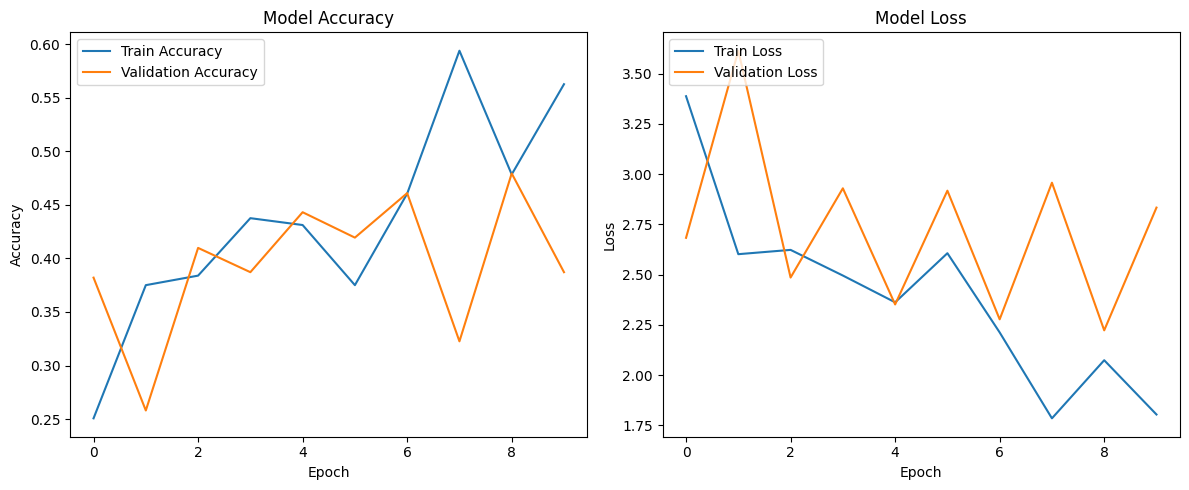

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


#### Observations

- Précision de l'entraînement et de la validation :

  La précision de l'entraînement montre une tendance à la hausse, ce qui est bon signe, mais reste quelque peu irrégulière.
  La précision de la validation fluctue de manière significative d'une époque à l'autre, ce qui indique une instabilité dans la capacité du modèle à généraliser.
  
- Perte de l'entraînement et de la validation :

  La perte de l'entraînement diminue, ce qui suggère que le modèle apprend à partir des données d'entraînement.
  La perte de la validation fluctue considérablement, ce qui indique souvent un surapprentissage ou une inadéquation entre les distributions des données d'entraînement et de validation.

#### Problèmes possibles

- Surapprentissage (Overfitting) : Le modèle semble s'adapter aux données d'entraînement, mais a du mal à généraliser sur l'ensemble de validation. Cela est suggéré par les fluctuations de la précision et de la perte de la validation.
- Ajustement insuffisant : Le modèle InceptionResNetV2 a été entièrement gelé (`trainable = False`). Bien que geler le modèle puisse prévenir le surapprentissage, cela peut également entraver la capacité du modèle à s'adapter à de nouvelles données, en particulier si le nouveau jeu de données diffère significativement d'ImageNet.
- Taux d'apprentissage et régularisation : Le taux d'apprentissage actuel est peut-être trop élevé pour la phase d'ajustement fin, ce qui amène le modèle à faire de grands pas et provoque des fluctuations de la précision et de la perte. De plus, il n'y a ni dropout ni régularisation L2 dans la tête du modèle, ce qui pourrait conduire à un surapprentissage.
- Déséquilibre des classes : Si le jeu de données est déséquilibré, cela peut entraîner des fluctuations dans les métriques de validation. Le code fourni ne gère pas le déséquilibre des classes.

## InceptionResNetV2 + weight balancing for minority classes during training + L2 regularisation and dropout

### Nous allons améliorer le modèle précédent en ajoutant podération des classes pour gerer le déséquilibre, ajouter L2 regularisation et dropout pout gerer l'Overfitting 

In [6]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

# adjusting target size and batch size to reduce computation
target_size = (160, 160)  # Reduce from (224, 224) to (160, 160)
batch_size = 16  # Reduce batch size to speed up training

# Training Data Generator with Reduced Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,            # Reduced rotation
    width_shift_range=0.1,        # Reduced width shift
    height_shift_range=0.1,       # Reduced height shift
    shear_range=0.1,              # Reduced shear transformation
    zoom_range=0.1,               # Reduced zoom
    horizontal_flip=True,         # Horizontal flip
    fill_mode='nearest',          # Filling strategy for newly created pixels
    rescale=1./255                # Normalization
)

# Validation Data Generator (No Augmentation, Only Rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='all_images/',          # Directory containing the images
    x_col='image_id',                 # Column containing image filenames
    y_col='category_id',              # Column containing class labels
    target_size=target_size,          # Resize images to smaller size (160, 160)
    batch_size=batch_size,            # Smaller batch size
    class_mode='categorical',         # Multi-class classification
    shuffle=True,                     # Shuffle the training data
    seed=42                           # Ensure reproducibility
)

# Validation Generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='all_images/',          # Directory containing the images
    x_col='image_id',                 # Column containing image filenames
    y_col='category_id',              # Column containing class labels
    target_size=target_size,          # Resize images to smaller size (160, 160)
    batch_size=batch_size,            # Smaller batch size
    class_mode='categorical',         # Multi-class classification
    shuffle=False                     # No shuffling for validation
)

# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['category_id']),
    y=df_train['category_id']
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Load the InceptionResNetV2 model
inception_resnet = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(160, 160, 3)))

# Unfreeze fewer layers for fine-tuning
for layer in inception_resnet.layers[:-5]:  # Freeze all but the last 5 layers
    layer.trainable = False

# Create the head of the model that will be placed on top of the pre-trained model
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)  # Flatten the output
headmodel = Dense(500, activation="relu", kernel_regularizer='l2')(headmodel)  # Dense layer with L2 regularization
headmodel = Dropout(0.5)(headmodel)  # Add dropout for regularization
headmodel = Dense(250, activation="relu", kernel_regularizer='l2')(headmodel)  # Dense layer with L2 regularization
headmodel = Dropout(0.5)(headmodel)  # Add dropout for regularization
headmodel = Dense(100, activation='softmax')(headmodel)  # Final output layer for 100 classes

# Construct the final model
model = Model(inputs=inception_resnet.input, outputs=headmodel)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks 
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, mode='min')

# Model Training
history = model.fit(
    train_generator,
    steps_per_epoch=len(df_train) // batch_size,  # Update steps_per_epoch based on the new batch size
    validation_data=val_generator,
    validation_steps=len(df_val) // batch_size,   # Update validation_steps based on the new batch size
    epochs=10,
    class_weight=class_weights_dict,  # Apply class weights
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Found 13820 validated image filenames belonging to 100 classes.
Found 3455 validated image filenames belonging to 100 classes.
Epoch 1/10


c:\Users\tariq\Desktop\Mirakl project\test_technique_cv\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


863/863 ━━━━━━━━━━━━━━━━━━━━ 963s 1s/step - accuracy: 0.0319 - loss: 15.1398 - val_accuracy: 0.1974 - val_loss: 8.9757 - learning_rate: 1.0000e-04
Epoch 2/10
  1/863 ━━━━━━━━━━━━━━━━━━━━ 10:28 730ms/step - accuracy: 0.0000e+00 - loss: 9.0859

C:\Users\tariq\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


863/863 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.0000e+00 - loss: 9.0859 - val_accuracy: 0.2667 - val_loss: 8.7267 - learning_rate: 1.0000e-04
Epoch 3/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 940s 1s/step - accuracy: 0.1144 - loss: 8.4710 - val_accuracy: 0.2727 - val_loss: 5.9707 - learning_rate: 1.0000e-04
Epoch 4/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.1250 - loss: 6.1729 - val_accuracy: 0.3333 - val_loss: 5.6367 - learning_rate: 1.0000e-04
Epoch 5/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 1044s 1s/step - accuracy: 0.1678 - loss: 6.1322 - val_accuracy: 0.2994 - val_loss: 4.7598 - learning_rate: 1.0000e-04
Epoch 6/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.1875 - loss: 5.0157 - val_accuracy: 0.3333 - val_loss: 4.5363 - learning_rate: 1.0000e-04
Epoch 7/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 944s 1s/step - accuracy: 0.2124 - loss: 5.1494 - val_accuracy: 0.3422 - val_loss: 4.1687 - learning_rate: 1.0000e-04
Epoch 8/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accur

## Saving the model

In [7]:
# Save the trained model if needed
model.save('best_model.keras')

## Evaluation of the validation

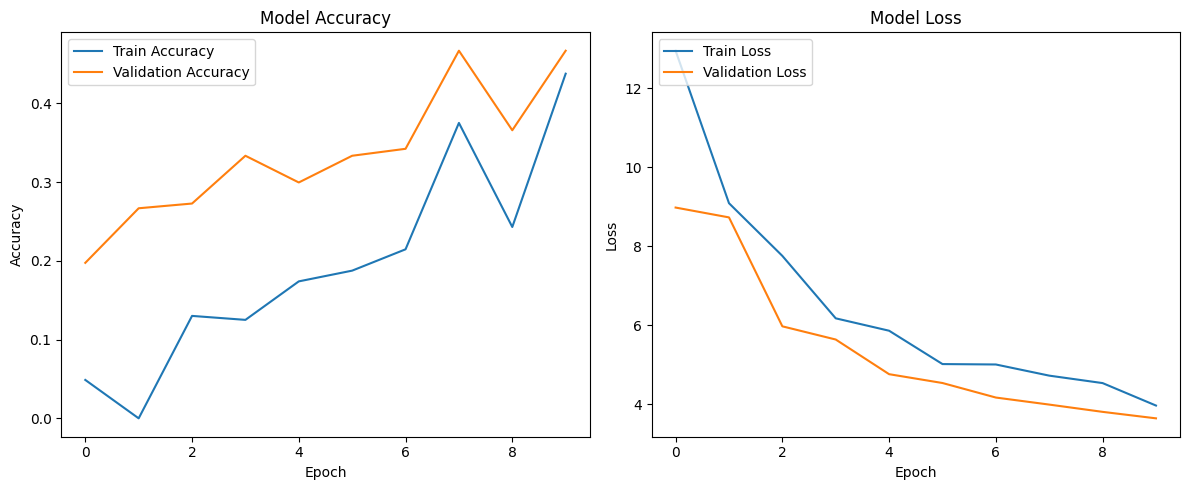

In [8]:
import matplotlib.pyplot as plt


# Plot the training and validation accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


### Observations des résultats de l'entraînement mis à jour

- Précision de l'entraînement et de la validation :

  La précision de l'entraînement et de la validation s'est améliorée par rapport à la précédente exécution. Cependant, la précision globale reste relativement basse, avec une précision d'entraînement atteignant un pic inférieur à 0,4, et une précision de validation légèrement plus élevée mais fluctuante.
  Le fait que la précision de la validation soit supérieure à celle de l'entraînement suggère que le modèle pourrait être en sous-apprentissage, possiblement parce que les couches du modèle pré-entraîné sont en grande partie gelées, limitant la capacité du modèle à apprendre les caractéristiques spécifiques du jeu de données.

- Perte de l'entraînement et de la validation :

  Les pertes d'entraînement et de validation diminuent régulièrement, ce qui est bon signe. Cela suggère que le modèle apprend et s'améliore avec le temps.
  La perte de validation est constamment inférieure à la perte d'entraînement, ce qui indique également un sous-apprentissage plutôt qu'un surapprentissage.

## Analyse : Mieux ou pire ?

- Meilleure stabilité : Le modèle montre une courbe d'apprentissage plus stable par rapport à l'exécution précédente. La réduction des fluctuations de la perte et la diminution régulière des pertes d'entraînement et de validation indiquent que la configuration d'entraînement actuelle est meilleure en termes de stabilité.
- Meilleure précision de validation : La précision de la validation est constamment plus élevée que lors des tentatives précédentes, ce qui est un signe positif. Cependant, la précision globale suggère qu'il y a encore de la marge pour l'amélioration.
- Sous-apprentissage : Le fait que la précision de la validation soit supérieure à la précision de l'entraînement et les niveaux de précision globaux faibles suggèrent que le modèle est en sous-apprentissage. Cela indique que le modèle n'a pas suffisamment appris à partir des données, possiblement parce que trop de couches du modèle pré-entraîné sont gelées ou que le taux d'apprentissage pour les couches non gelées est trop faible.

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

# Adjust target size and batch size to reduce computation
target_size = (160, 160)  # Reduce from (224, 224) to (160, 160)
batch_size = 16  # Reduce batch size to speed up training

# Training Data Generator with Reduced Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,            # Reduced rotation
    width_shift_range=0.1,        # Reduced width shift
    height_shift_range=0.1,       # Reduced height shift
    shear_range=0.1,              # Reduced shear transformation
    zoom_range=0.1,               # Reduced zoom
    horizontal_flip=True,         # Horizontal flip
    fill_mode='nearest',          # Filling strategy for newly created pixels
    rescale=1./255                # Normalization
)

# Validation Data Generator (No Augmentation, Only Rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='all_images/',          # Directory containing the images
    x_col='image_id',                 # Column containing image filenames
    y_col='category_id',              # Column containing class labels
    target_size=target_size,          # Resize images to smaller size (160, 160)
    batch_size=batch_size,            # Smaller batch size
    class_mode='categorical',         # Multi-class classification
    shuffle=True,                     # Shuffle the training data
    seed=42                           # Ensure reproducibility
)

# Validation Generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='all_images/',          # Directory containing the images
    x_col='image_id',                 # Column containing image filenames
    y_col='category_id',              # Column containing class labels
    target_size=target_size,          # Resize images to smaller size (160, 160)
    batch_size=batch_size,            # Smaller batch size
    class_mode='categorical',         # Multi-class classification
    shuffle=False                     # No shuffling for validation
)

# Load the previously saved model file
model = load_model('best_model.keras')  # Replace with the correct path to your saved model

# Here, we unfreeze all layers, but you can selectively unfreeze layers if desired
for layer in model.layers:
    layer.trainable = True  # Set all layers to be trainable

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['category_id']),
    y=df_train['category_id']
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}



model.compile(optimizer=Adam(learning_rate=1e-5),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Reuse the callbacks to ensure best model saving and learning rate adjustment
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_continued.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, mode='min')

# Continue training the model for an additional 10 epochs
history = model.fit(
    train_generator,
    steps_per_epoch=len(df_train) // batch_size,  
    validation_steps=len(df_val) // batch_size,  
    epochs=10,  # Train for additional 10 epochs
    class_weight=class_weights_dict,  
    callbacks=[early_stopping, model_checkpoint, reduce_lr] 
)


Found 13820 validated image filenames belonging to 100 classes.
Found 3455 validated image filenames belonging to 100 classes.
Epoch 1/10


c:\Users\tariq\Desktop\Mirakl project\test_technique_cv\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


863/863 ━━━━━━━━━━━━━━━━━━━━ 2559s 3s/step - accuracy: 0.1547 - loss: 4.9156 - val_accuracy: 0.3410 - val_loss: 3.8701 - learning_rate: 1.0000e-05
Epoch 2/10
  1/863 ━━━━━━━━━━━━━━━━━━━━ 2:19:10 10s/step - accuracy: 0.3750 - loss: 4.4539

C:\Users\tariq\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


863/863 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.3750 - loss: 4.4539 - val_accuracy: 0.2667 - val_loss: 4.0204 - learning_rate: 1.0000e-05
Epoch 3/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 2761s 3s/step - accuracy: 0.2574 - loss: 4.2533 - val_accuracy: 0.3811 - val_loss: 3.5814 - learning_rate: 1.0000e-05
Epoch 4/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2500 - loss: 4.0706 - val_accuracy: 0.4667 - val_loss: 3.6301 - learning_rate: 1.0000e-05
Epoch 5/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 2664s 3s/step - accuracy: 0.2891 - loss: 4.0377 - val_accuracy: 0.4026 - val_loss: 3.4525 - learning_rate: 1.0000e-05
Epoch 6/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1875 - loss: 4.9419 - val_accuracy: 0.4667 - val_loss: 3.4586 - learning_rate: 1.0000e-05
Epoch 7/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 2375s 3s/step - accuracy: 0.3145 - loss: 3.8351 - val_accuracy: 0.4177 - val_loss: 3.3494 - learning_rate: 1.0000e-05
Epoch 8/10
863/863 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.

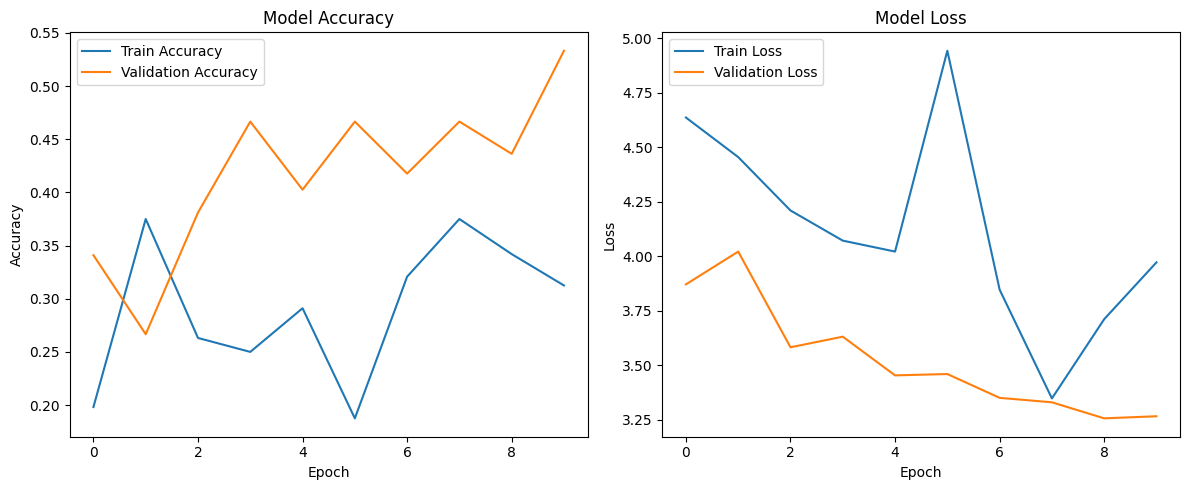

In [15]:
import matplotlib.pyplot as plt


# Plot the training and validation accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


**Analyse des courbes d'entraînement et de validation**

1. **Précision et perte d'entraînement :**
   - La précision d'entraînement commence à un niveau bas et fluctue au fil des époques, montrant une instabilité dans le processus d'apprentissage.
   - La perte d'entraînement diminue globalement, mais il y a des pics indiquant que le modèle a du mal à minimiser la perte de manière cohérente. Le pic observé vers le milieu de l'entraînement suggère que le modèle pourrait atteindre des minima locaux ou avoir des difficultés à apprendre certaines caractéristiques.

2. **Précision et perte de validation :**
   - La perte de validation diminue de manière constante et montre moins de fluctuations par rapport à la perte d'entraînement. Cela peut indiquer que le modèle s'améliore en termes de généralisation, mais il a encore du mal à atteindre une haute précision.

3. **Entraînement vs Validation :**
   - Il existe un écart significatif entre la précision d'entraînement et la précision de validation, la précision de validation étant systématiquement plus élevée que la précision d'entraînement.
     - **Under-fitting :** Le modèle pourrait ne pas avoir suffisamment appris les motifs dans les données d'entraînement. Cela pourrait être dû à une régularisation excessive (comme le dropout ou la régularisation L2), à un nombre insuffisant d'époques d'entraînement, ou à une architecture de modèle pas assez complexe pour le jeu de données.
     - **Effets de régularisation :** des taux de dropout élevés ou une régularisation L2 pourraient empêcher le modèle d'apprendre des motifs suffisamment complexes, entraînant une précision d'entraînement plus faible. Cependant, ces techniques de régularisation ont aider le modèle à mieux généraliser et éviter l'overfitting.

4. **Pics dans la perte d'entraînement :**
   - Les pics dans la courbe de perte d'entraînement, en particulier vers le milieu de l'entraînement, peuvent suggérer une instabilité dans le processus d'apprentissage. Les raisons possibles incluent :
     - **Taux d'apprentissage :**  taux d'apprentissage élevé, le modèle peut osciller ou diverger, provoquant des pics dans la perte.
     - **Complexité des données :** les données d'entraînement peuvent contenir des motifs complexes ou du bruit que le modèle a du mal à apprendre, entraînant ces fluctuations.

### Utilisation d'un autre modèle pré-entrainé EfficientNetB0 et Oversampling technique

In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Step 1: Load and Prepare Dataset ---
df_combined = pd.read_csv('data/clean_trainset.csv') 
df_train, df_val = train_test_split(df_combined, test_size=0.2, stratify=df_combined['category_id'], random_state=42)

# --- Step 2: Data Generators with Oversampling ---
target_size = (224, 224)  
batch_size = 16

# Training Data Generator with Oversampling and Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

# Create an oversampled dataset by repeating rows of minority classes
max_samples = df_train['category_id'].value_counts().max()
df_train_oversampled = df_train.groupby('category_id', group_keys=False).apply(lambda x: x.sample(max_samples, replace=True))
df_train_oversampled = df_train_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the oversampled dataset

# Validation Data Generator (No Augmentation, Only Rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_oversampled,
    directory='all_images/',
    x_col='image_id',
    y_col='category_id',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Validation Generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='all_images/',
    x_col='image_id',
    y_col='category_id',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the InceptionResNetV2 model
efficient_net = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Unfreeze the last 10 layers for fine-tuning
for layer in efficient_net.layers[:-6]:
    layer.trainable = False

headmodel = efficient_net.output
headmodel = Flatten()(headmodel)  # Flatten the output
headmodel = Dense(500, activation="relu", kernel_regularizer='l2')(headmodel)  # Dense layer with L2 regularization
headmodel = Dropout(0.5)(headmodel)  # Add dropout for regularization
headmodel = Dense(250, activation="relu", kernel_regularizer='l2')(headmodel)  # Dense layer with L2 regularization
headmodel = Dropout(0.5)(headmodel)  # Add dropout for regularization
headmodel = Dense(100, activation='softmax')(headmodel)  # Final output layer for 100 classes

# Construct the final model
model = Model(inputs=efficient_net.input, outputs=headmodel)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_efficientnet_oversampled.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

# Learning Rate Schedule Function
def lr_schedule(epoch, lr):
    # Decrease learning rate by a factor of 0.5 every 5 epochs
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Model Training with Learning Rate Scheduler ---
history = model.fit(
    train_generator,
    steps_per_epoch=len(df_train_oversampled) // batch_size,
    validation_data=val_generator,
    validation_steps=len(df_val) // batch_size,
    epochs=10,  # Adjust epochs based on convergence
    callbacks=[early_stopping, model_checkpoint, reduce_lr, lr_scheduler]
)

model.save('efficientnet_oversampled_final_model.keras')


C:\Users\tariq\AppData\Local\Temp\ipykernel_12748\851583946.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_oversampled = df_train.groupby('category_id', group_keys=False).apply(lambda x: x.sample(max_samples, replace=True))


Found 22100 validated image filenames belonging to 100 classes.
Found 3455 validated image filenames belonging to 100 classes.
Epoch 1/10


c:\Users\tariq\Desktop\Mirakl project\test_technique_cv\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1381/1381 ━━━━━━━━━━━━━━━━━━━━ 2845s 2s/step - accuracy: 0.0167 - loss: 17.6329 - val_accuracy: 0.1506 - val_loss: 15.8923 - learning_rate: 1.0000e-05
Epoch 2/10
   1/1381 ━━━━━━━━━━━━━━━━━━━━ 1:08:21 3s/step - accuracy: 0.1250 - loss: 16.0213

C:\Users\tariq\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1381/1381 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.1250 - loss: 16.0213 - val_accuracy: 0.0667 - val_loss: 15.8676 - learning_rate: 1.0000e-05
Epoch 3/10
 403/1381 ━━━━━━━━━━━━━━━━━━━━ 29:08 2s/step - accuracy: 0.0461 - loss: 15.9435

Un problème de Hardware m'a poussé a arrété l'entrainnement, On se contontera des modèles entrainés

## Synthèse

---

- Nous avons réussi à developpé deux modèle de classification :

        - best_model_10_epoch.keras

        - best_model_continued_20_epoch.keras
        
- Ces modèles sont enregitrer dans le dossier \models
- Ces modèles nécessite encore quelques amélioration mais semble converger vers un modèle performant. 
- Voir l'évaluation sur le dataset de test ([test_evaluation](test_evaluation.ipynb)) pour juger correctement les performances avec des métriques de classification